<a href="https://colab.research.google.com/github/anastasiarenata1/deeplearning/blob/main/LNN_with_Numpy_and_Softmax_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4 - Regression

 

* Explore three shallow (linear) neural network models with different activation functions for this task.
* Evaluate the model by rounding the output of your linear neural network and compute the mean squared error


###1. Load and explore the data

In [8]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
!unzip YearPredictionMSD.txt.zip

--2023-03-01 18:38:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘YearPredictionMSD.txt.zip’

YearPredictionMSD.t 100%[===================>] 201.24M  17.1MB/s    in 14s     

2023-03-01 18:38:31 (14.9 MB/s) - ‘YearPredictionMSD.txt.zip’ saved [211011981/211011981]

Archive:  YearPredictionMSD.txt.zip
  inflating: YearPredictionMSD.txt   


In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
colnames = ['target'] + ['timbre_avg_' + str(i) for i in range(1, 13)] + ['timbre_covar_' + str(i) for i in range(1, 79)]
df = pd.read_csv('YearPredictionMSD.txt', header=None, names=colnames)
df.head(5)

,target,timbre_avg_1,timbre_avg_2,timbre_avg_3,timbre_avg_4,timbre_avg_5,timbre_avg_6,timbre_avg_7,timbre_avg_8,timbre_avg_9,...,timbre_covar_69,timbre_covar_70,timbre_covar_71,timbre_covar_72,timbre_covar_73,timbre_covar_74,timbre_covar_75,timbre_covar_76,timbre_covar_77,timbre_covar_78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Write a function to load the dataset, e.g.,
`trainYears, trainFeat, testYears, testFeat = loadMusicData(fname, addBias)`

In [3]:
def loadMusicData(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  return train_y, train_x, test_y, test_x

Write a function `mse = musicMSE(pred, gt)` where the inputs are the predicted year and the “ground truth” year from the dataset. The function computes the mean squared error(MSE) by rounding pred before computing the MSE.

In [4]:
from sklearn.metrics import mean_squared_error
def musicMSE(pred, gt):
  pred = np.round(pred)
  mse= mean_squared_error(pred, gt)
  return mse

Load the dataset and discuss its properties. 
1. What is the range of the variables? From 90 attributes, range of variables for timbre average is tighter than range of variables for timbre covariance. However, within each category itself, some attributes have wider range compared to others, in which we don't have further documentation to explain this event.
2. How might you normalize them? Normalization can help to ensure that each variables contribute equally to the model. Since range of variables varies significantly accross 90 attributes, I will normalize the data using standardization technique (0 mean and unit std deviation for each attribute) where we can help to preserve importance of variables.
3. What years are represented in the dataset? The dataset covers song released from 1922 to 2011 (90 years) with most common year of 2007.
4. What will the test mean squared error (MSE) be if your classifier always outputs the most common year in the dataset? 190.08

In [6]:
# Range of variables
var_ranges = np.ptp(df.iloc[:, 1:].values, axis=0)
for i, var_range in enumerate(var_ranges):
    print("Variable {}: range = {:.0f}".format(i+1, var_range))

Variable 1: range = 60
Variable 2: range = 721
Variable 3: range = 624
Variable 4: range = 490
Variable 5: range = 444
Variable 6: range = 248
Variable 7: range = 361
Variable 8: range = 199
Variable 9: range = 273
Variable 10: range = 102
Variable 11: range = 158
Variable 12: range = 182
Variable 13: range = 550
Variable 14: range = 65727
Variable 15: range = 36796
Variable 16: range = 31832
Variable 17: range = 19854
Variable 18: range = 16826
Variable 19: range = 11882
Variable 20: range = 9564
Variable 21: range = 9610
Variable 22: range = 3707
Variable 23: range = 6731
Variable 24: range = 9808
Variable 25: range = 4871
Variable 26: range = 37870
Variable 27: range = 26522
Variable 28: range = 7735
Variable 29: range = 6635
Variable 30: range = 6669
Variable 31: range = 6153
Variable 32: range = 3471
Variable 33: range = 4567
Variable 34: range = 3921
Variable 35: range = 2803
Variable 36: range = 4208
Variable 37: range = 22597
Variable 38: range = 18155
Variable 39: range = 1586

In [14]:
#Normalize data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def loadMusicData2(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  train_x= scaler.fit_transform(train_x)
  test_x= scaler.fit_transform(test_x)

  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  

  return train_y, train_x, test_y, test_x

In [8]:
#Years represented
print('Min years presented: ', np.min(df['target']))
print('Max years presented: ', np.max(df['target']))
print('Median years presented: ', np.median(df['target']))

from statistics import mode
print('Most common year:', mode(df['target']))

Min years presented:  1922
Max years presented:  2011
Median years presented:  2002.0
Most common year: 2007


In [15]:
train_y, train_x, test_y, test_x = loadMusicData2(df, addBias=True)

In [10]:
#test MSE
musicMSE(torch.full((test_y.shape[0],), 2007), test_y)

190.08239236117836

##2. Classification
This problem could have been posed as a classification problem by treating each year as a category. What would be the problems with this approach? Support your argument by analyzing a bar chart with the year as the x-axis and the number of examples for that year as the y-axis.

As we can see from the chart, the distribution of train dataset is skewed to the left where majority of the data coming from the later years. If we treat this problem as a classification problem, the model will be biased and will be more likely to predict later years. Furthermore, classification means that the predicted data will be categorical values instead of continuous which can result in loss of information as repercussion. 

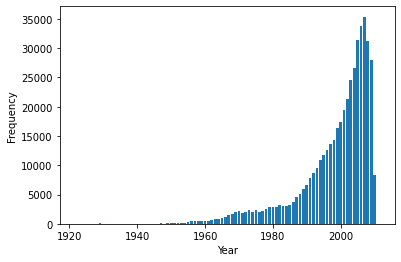

In [18]:
#plot year frequency from train dataset
import matplotlib.pyplot as plt
train_df = df[:463714]
year_counts = train_df.iloc[:, 0].value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

##3. Ridge regression

* Implement stochastic gradient descent with mini-batches to minimize the loss and evaluate the train and test MSE.
* Tune the learning rate and weight decay factor. 
* Show the train and test loss as a function of epochs, where the number of epochs should be chosen to ensure the train loss is minimized.

In [60]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, batch_size=32, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='L2', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = 0
    train_losses = []
    test_losses = []

    def forward(X, w):
        return np.dot(X, w)

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
        error = None
        if loss_type == "L2":
            error = 2*(y_pred - y)
        elif loss_type == "count":
            error = np.round(y_pred) - np.round(y)
        elif loss_type == "cross-entropy":
            error = y_pred - y
        elif loss_type == 'L1':
            error = np.sign(y_pred - y)

        gradient = backward(X, error)
        if weight_decay_form == 'L2':
            gradient += weight_decay_factor * w
        elif weight_decay_form == 'L1':
            gradient += weight_decay_factor * np.sign(w)

        return gradient, error

    def compute_loss(y, y_pred, loss_type):
        if loss_type == "L2":
            return np.mean(np.square(y - y_pred))
        elif loss_type == "count":
            return np.mean(np.abs(np.round(y) - np.round(y_pred)))
        elif loss_type == "cross-entropy":
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
            return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        elif loss_type == 'L1':
            return np.mean(np.abs(y - y_pred))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
                m = momentum_factor * m + (1 - momentum_factor) * gradient
                weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

    return weight, train_losses, test_losses


Hyperparameter tuning
* Learning rate= 0.0001
* Weight decay factor= 0.000001
* Batch size=16
* Number epochs=100
* Loss type= L2
* Weight decay form= None
* No momentum



In [85]:
w_ridge, train_loss_ridge, test_loss_ridge = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=16, num_epochs=100, learning_rate=0.000001, weight_decay_factor=0.000001, loss_type='L2', weight_decay_form=None, momentum=False, momentum_factor=None)

Epoch: 1 /100, Train loss: 624334.7172057558 Test loss: 624506.8071163731
Epoch: 2 /100, Train loss: 97764.00715553298 Test loss: 97831.08836870485
Epoch: 3 /100, Train loss: 15376.876114026396 Test loss: 15402.916746028322
Epoch: 4 /100, Train loss: 2485.894287512868 Test loss: 2495.7350251214193
Epoch: 5 /100, Train loss: 467.6722684729137 Test loss: 471.04395884129235
Epoch: 6 /100, Train loss: 151.5215729836239 Test loss: 152.34805384817923
Epoch: 7 /100, Train loss: 101.6189731477869 Test loss: 101.4208206769924
Epoch: 8 /100, Train loss: 93.57678692793895 Test loss: 93.03487542910948
Epoch: 9 /100, Train loss: 92.12989423286825 Test loss: 91.39301950954511
Epoch: 10 /100, Train loss: 91.77957550908967 Test loss: 91.03746336867296
Epoch: 11 /100, Train loss: 91.64154519544923 Test loss: 90.81349278108068
Epoch: 12 /100, Train loss: 91.5470153948017 Test loss: 90.73043691194243
Epoch: 13 /100, Train loss: 91.48415453139468 Test loss: 90.69478139700956
Epoch: 14 /100, Train loss: 91

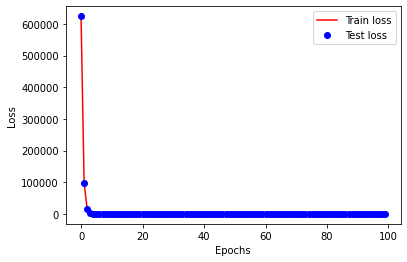

In [86]:
num_epochs=100
plt.plot(range(num_epochs), train_loss_ridge,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_ridge, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Pseudoinverse

In [81]:
def compute_loss(X, y, weight, loss_type):
    if loss_type == 'L2':
        loss = np.mean((np.dot(X, weight) - y) ** 2)
    elif loss_type == 'count':
        loss = np.mean(np.abs(np.dot(X, weight) - y))
    elif loss_type == 'cross-entropy':
        exp_term = np.exp(np.dot(X, weight))
        loss = np.mean(np.log(1 + exp_term) - y * np.dot(X, weight))
    return loss

def pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2'):
    pseudoinv= np.dot(np.linalg.inv(train_x.T.dot(train_x) + alpha*np.eye(train_x.shape[1])), train_x.T)
    weight= np.dot(pseudoinv, train_y)
    train_y_predict= np.dot(train_x, weight)
    test_y_predict= np.dot(test_x, weight)

    train_loss= compute_loss(train_x, train_y, weight, loss_type=loss_type)
    test_loss= compute_loss(test_x, test_y,weight, loss_type=loss_type)
  
    print(f'Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')
    
    return weight, train_loss, test_loss

In [82]:
weight_inverse, train_loss_inverse, test_loss_inverse = pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2')

Train loss: 91.2564, Test loss: 90.4911


##4. Implement L1 weight decay

Epoch: 1 /100, Train loss: 1533.9298342370594 Test loss: 1534.0396808975281
Epoch: 2 /100, Train loss: 1070.2161240682008 Test loss: 1070.32597072867
Epoch: 3 /100, Train loss: 606.5024138995116 Test loss: 606.6122605599807
Epoch: 4 /100, Train loss: 142.7943934598891 Test loss: 142.90255039129102
Epoch: 5 /100, Train loss: 6.525489093275993 Test loss: 6.547463616648306
Epoch: 6 /100, Train loss: 6.526913370934475 Test loss: 6.539455055410475
Epoch: 7 /100, Train loss: 6.527716644145912 Test loss: 6.544727467041571
Epoch: 8 /100, Train loss: 6.5324472719842435 Test loss: 6.535645737222449
Epoch: 9 /100, Train loss: 6.524034958067726 Test loss: 6.534396182127024
Epoch: 10 /100, Train loss: 6.529765053160662 Test loss: 6.549688218464513
Epoch: 11 /100, Train loss: 6.525060021006106 Test loss: 6.551036981024762
Epoch: 12 /100, Train loss: 6.529173478380311 Test loss: 6.532904338219348
Epoch: 13 /100, Train loss: 6.534003733999814 Test loss: 6.545883799220249
Epoch: 14 /100, Train loss: 6.

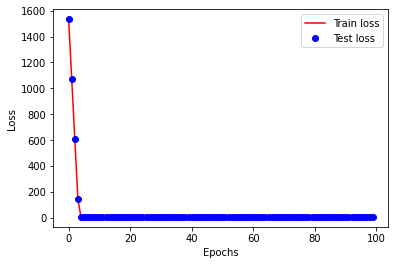

In [91]:
w_lasso, train_loss_lasso, test_loss_lasso = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=16, num_epochs=100, learning_rate=0.001, weight_decay_factor=0.00001, loss_type='L1', weight_decay_form='L1', momentum=False, momentum_factor=None)
num_epochs=100
plt.plot(range(num_epochs), train_loss_lasso,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_lasso, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##5. Count Regression

$$y_{pred} = e^{w^T X}$$
$$L(y, y_{pred}) = e^{-y_{pred}} y_{pred}^y / y!$$
$$L(w) = -\sum_{i=1}^{n}(y_i log(y_{pred,i}) - y_{pred,i})$$
$$ w_{t+1} = w_t - \eta \nabla J(w_t) $$

In [83]:
def count_regression(X_train, y_train, X_test, y_test, batch_size=16, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='count', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = 0
    train_losses = []
    test_losses = []

    def forward(X, w):
      # Clip X * w to avoid overflow in the exponential function
      Xw = np.clip(np.dot(X, w), -100, None)
      # Apply the exponential function and replace any resulting inf or nan values
      y_pred = np.where(np.isinf(np.exp(Xw)), 1e10, np.exp(np.clip(Xw, -500, 500)))
      return y_pred

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
      error = None
      if loss_type == "L2":
          error = 2*(y_pred - y)
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          error = np.exp(-y_pred_clipped) * (y_pred - y)
      elif loss_type == "cross-entropy":
          error = y_pred - y

      gradient = backward(X, error)
      if weight_decay_form == 'L2':
          gradient += weight_decay_factor * w
      elif weight_decay_form == 'L1':
          gradient += weight_decay_factor * np.sign(w)

      return gradient, error


    def compute_loss(y, y_pred, loss_type):
      if loss_type == "L2":
          return np.mean(np.square(y - y_pred))
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          return np.mean(np.exp(-y_pred_clipped) * np.square(y - y_pred))
      elif loss_type == "cross-entropy":
          y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
          return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
      elif loss_type == 'L1':
          return np.mean(np.abs(y - y_pred))
      else:
          raise ValueError("Invalid loss type: {}".format(loss_type))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
                m = momentum_factor * m + (1 - momentum_factor) * gradient
                weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

        # Check if the test loss has stopped decreasing
        if len(test_losses) >= 2 and test_losses[-1] >= test_losses[-2]:
            print("Test loss has stopped decreasing. Stopping training.")
            break

    return weight, train_losses, test_losses

In [84]:
w, train_loss, test_loss= count_regression(train_x, train_y, test_x, test_y, batch_size=16, num_epochs=100, learning_rate=0.0001, weight_decay_factor=0.0001, loss_type='L2', weight_decay_form='L1', momentum=False, momentum_factor=0.9)

<ipython-input-83-4fd2562a219d>:13: RuntimeWarning: overflow encountered in exp
  y_pred = np.where(np.isinf(np.exp(Xw)), 1e10, np.exp(np.clip(Xw, -500, 500)))


Epoch: 1 /100, Train loss: 1.380160495777983e+16 Test loss: 1.5494561018500892e+16
Epoch: 2 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Epoch: 3 /100, Train loss: 3993666.588416567 Test loss: 1936820130274826.5
Test loss has stopped decreasing. Stopping training.


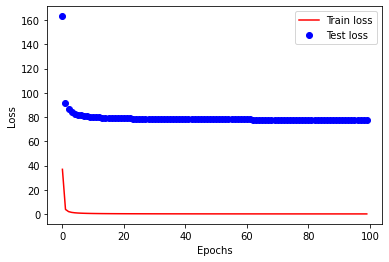

In [41]:
num_epochs=100
plt.plot(range(num_epochs), train_loss,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##6. Model comparison


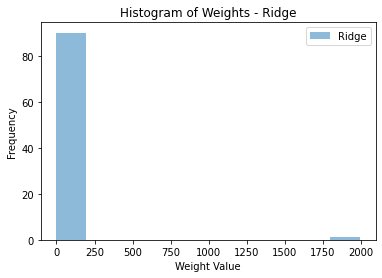

In [101]:
# fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(w_ridge, alpha=0.5, label='Ridge')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Ridge')
plt.show()

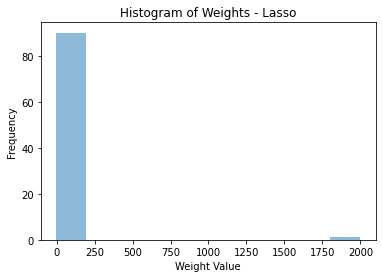

In [102]:
plt.hist(w_lasso, alpha=0.5, label='Lasso')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Lasso')
plt.show()

# Problem 5 - Softmax Properties


###1. Show that the softmax function is invariant to constant offsets to its input

\begin{align*}
softmax(a+c1) &= \frac{exp(a+c1)}{\sum_{j=1}^{n}exp(a_j+c)} \\
&= \frac{exp(a)exp(c1)}{\sum_{j=1}^{n}exp(a_j)exp(c)}\\
&= \frac{exp(a)}{\sum_{j=1}^{n}exp(a_j)} \times \frac{exp(c1)}{\sum_{j=1}^{n}exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1)}{n \times exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1-c)}{n}
\end{align*}

Since $\frac{exp(c1-c)}{n}$ is a constant, it doesn't depend on $a$ and it's proven that softmax function is invariant to constant offset to its input.


###2.  